In [2]:
import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import matplotlib.pyplot as plt # this is used for the plot the graph 
import tensorflow_probability as tfp
from tqdm import tnrange, tqdm_notebook
import seaborn as sns
import tensorflow as tf
from scipy import stats
from tqdm import notebook
from sklearn.model_selection import KFold

import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from torch.autograd import Variable
np.random.seed(0)
torch.manual_seed(0)

device = torch.device("cpu")


In [3]:
%matplotlib inline

### Simulate Data

In [4]:
np.random.seed(2020)

# generate weibull distribution parameter
shape=np.random.uniform(1,5,1000)
scale=np.random.uniform(0.5,2,1000)


# the full design matrix
x=np.c_[shape,scale]


y=(np.random.weibull(shape,size=1000)*scale).reshape(-1,1)


train_x=x[:700,:]
train_y=y[:700,:]

test_x=x[700:,:]
test_y=y[700:,:]

ntrain=len(train_x)
ntest=len(test_x)



Code refer to {https://github.com/yaringal/DropoutUncertaintyExps/blob/master/net}


hetero dp: 
https://github.com/yaringal/HeteroscedasticDropoutUncertainty

https://github.com/yaringal/ConcreteDropout/blob/master/concrete-dropout-pytorch.ipynb

### CDP Model

In [5]:
class ConcreteDropout(nn.Module):
    def __init__(self, weight_regularizer=1e-6,
                 dropout_regularizer=1e-5, init_min=0.1, init_max=0.1):
        super(ConcreteDropout, self).__init__()

        
        self.weight_regularizer = weight_regularizer
        self.dropout_regularizer = dropout_regularizer
        
        init_min = np.log(init_min) - np.log(1. - init_min)
        init_max = np.log(init_max) - np.log(1. - init_max)
        
        self.p_logit = nn.Parameter(torch.empty(1).uniform_(init_min, init_max))
        
    def forward(self, x, layer):
        p = torch.sigmoid(self.p_logit)
        
        out = layer(self._concrete_dropout(x, p))
        
        sum_of_square = 0
        for param in layer.parameters():
            sum_of_square += torch.sum(torch.pow(param, 2))
        
        weights_regularizer = self.weight_regularizer * sum_of_square / (1 - p)
        
        dropout_regularizer = p * torch.log(p)
        dropout_regularizer += (1. - p) * torch.log(1. - p)
        
        input_dimensionality = x[0].numel() # Number of elements of first item in batch
        dropout_regularizer *= self.dropout_regularizer * input_dimensionality
        
        regularization = weights_regularizer + dropout_regularizer
        return out, regularization
        
    def _concrete_dropout(self, x, p):
        eps = 1e-7
        temp = 0.1

        unif_noise = torch.rand_like(x)

        drop_prob = (torch.log(p + eps)
                    - torch.log(1 - p + eps)
                    + torch.log(unif_noise + eps)
                    - torch.log(1 - unif_noise + eps))
        
        drop_prob = torch.sigmoid(drop_prob / temp)
        random_tensor = 1 - drop_prob
        retain_prob = 1 - p
        
        x  = torch.mul(x, random_tensor)
        x /= retain_prob
        
        return x

In [6]:
class Model(nn.Module):
    def __init__(self, weight_regularizer, dropout_regularizer):
        super(Model, self).__init__()
        self.linear1 = nn.Linear(2, 100)
        self.linear2 = nn.Linear(100, 80)

        self.linear3_mu = nn.Linear(80, 1)
        self.linear3_logvar = nn.Linear(80, 1)

        self.conc_drop1 = ConcreteDropout(weight_regularizer=weight_regularizer,
                                          dropout_regularizer=dropout_regularizer)
        self.conc_drop2 = ConcreteDropout(weight_regularizer=weight_regularizer,
                                          dropout_regularizer=dropout_regularizer)
        self.conc_drop_mu = ConcreteDropout(weight_regularizer=weight_regularizer,
                                             dropout_regularizer=dropout_regularizer)
        self.conc_drop_logvar = ConcreteDropout(weight_regularizer=weight_regularizer,
                                                 dropout_regularizer=dropout_regularizer)
        
        self.elu = nn.ELU()
        
    def forward(self, x):
        regularization = torch.empty(4, device=x.device)
        
        x1, regularization[0] = self.conc_drop1(x, nn.Sequential(self.linear1, self.elu))
        x2, regularization[1] = self.conc_drop2(x1, nn.Sequential(self.linear2, self.elu))

        mean, regularization[2] = self.conc_drop_mu(x2, self.linear3_mu)
        log_var, regularization[3] = self.conc_drop_logvar(x2, self.linear3_logvar)

        return mean, log_var, regularization.sum()

def heteroscedastic_loss(true, mean, log_var):
    precision = torch.exp(-log_var)
    return torch.mean(torch.sum(precision * (true - mean)**2 + log_var, 1), 0)

In [7]:
nb_epochs = 300
Q = 2 # Data dimensionality
D = 1 # One mean, one log_var
batch_size = 128
l = 1e-4 # Lengthscale

def fit_model(nb_epoch, X, Y):
    N = X.shape[0]
    wr = l**2. / N
    dr = 2. / N
    model = Model(wr, dr)
    model = model.to(device)
    optimizer = optim.Adam(model.parameters())
    
    for i in range(nb_epoch):
        old_batch = 0
        for batch in range(int(np.ceil(X.shape[0]/batch_size))):
            batch = (batch + 1)
            _x = X[old_batch: batch_size*batch]
            _y = Y[old_batch: batch_size*batch]
            
            x = Variable(torch.FloatTensor(_x)).to(device)
            y = Variable(torch.FloatTensor(_y)).to(device)
            
            mean, log_var, regularization = model(x)
                        
            loss = heteroscedastic_loss(y, mean, log_var) + regularization
             
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
    return model


### Single Evaluation

In [8]:
model = fit_model(nb_epochs, train_x, train_y)
model.eval()


Model(
  (linear1): Linear(in_features=2, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=80, bias=True)
  (linear3_mu): Linear(in_features=80, out_features=1, bias=True)
  (linear3_logvar): Linear(in_features=80, out_features=1, bias=True)
  (conc_drop1): ConcreteDropout()
  (conc_drop2): ConcreteDropout()
  (conc_drop_mu): ConcreteDropout()
  (conc_drop_logvar): ConcreteDropout()
  (elu): ELU(alpha=1.0)
)

In [9]:
MC_samples = [model(Variable(torch.FloatTensor(test_x)).to(device)) for _ in range(1000)]
means = torch.stack([tup[0] for tup in MC_samples]).view(1000, test_x.shape[0]).cpu().data.numpy()
logvar = torch.stack([tup[1] for tup in MC_samples]).view(1000, test_x.shape[0]).cpu().data.numpy()

muest=means.mean(0)
stdest=np.sqrt(np.exp(logvar).mean(0))

#### P(Y>1|x)

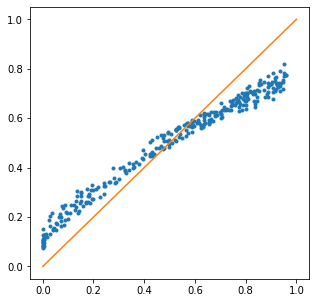

In [13]:
#true
tsuv1=1-stats.weibull_min.cdf(1,c=test_x[:,0],scale=test_x[:,1])

#cdf estimate by g
cdpsuv1=1.-(stats.norm.cdf((1.-muest)/stdest))

plt.figure(figsize=(5,5))
plt.plot(tsuv1,cdpsuv1,'.')

plt.plot([0,1],[0,1])
np.save('cdpsuv_est',cdpsuv1)

#### recovery of true cdf

In [15]:
#gdperate sample
np.random.seed(3421)
samps=np.random.choice(len(test_x),3)
yrange=xtmp=np.linspace(-2,7,5000) #gaussian can go below 0
## mean and sd for dp sample
cdpmusd=np.c_[muest,stdest][samps]
cdpmusd

array([[1.1638175 , 1.1740603 ],
       [0.8373021 , 0.391185  ],
       [1.1850221 , 0.83857816]], dtype=float32)

/Users/tz/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


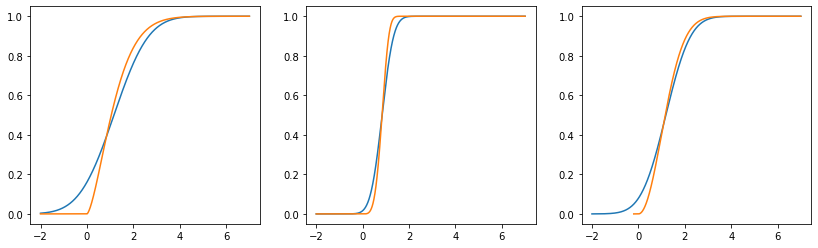

In [18]:
plt.figure(figsize=(14,4))
plt.subplot(131)

plt.subplot(1,3,1)
i=samps[0]
tcdf=tcdf=stats.weibull_min.cdf(x=yrange,c=test_x[i,0],scale=test_x[i,1])
cdpcdf=stats.norm.cdf((yrange-cdpmusd[0,0])/cdpmusd[0,1])

plt.plot(yrange,cdpcdf)
plt.plot(yrange,tcdf)




plt.subplot(1,3,2)
i=samps[1]
tcdf=tcdf=stats.weibull_min.cdf(x=yrange,c=test_x[i,0],scale=test_x[i,1])
cdpcdf=stats.norm.cdf((yrange-cdpmusd[1,0])/cdpmusd[1,1])

plt.plot(yrange,cdpcdf)
plt.plot(yrange,tcdf)



plt.subplot(1,3,3)
i=samps[2]
tcdf=tcdf=stats.weibull_min.cdf(x=yrange,c=test_x[i,0],scale=test_x[i,1])
cdpcdf=stats.norm.cdf((yrange-cdpmusd[2,0])/cdpmusd[2,1])

plt.plot(yrange,cdpcdf)
plt.plot(yrange[1000:],tcdf[1000:])


### Ten replications to evaluate the hard metrics

In [25]:
##function to create replication
def rep_iter(x,y,frac=0.3):
    n=len(x)
    ntest=int(np.floor(frac*n))
    allidx=np.random.permutation(n)
    trainidx= allidx[ntest:]
    testidx= allidx[:ntest]
    return x[trainidx],y[trainidx],x[testidx],y[testidx]
    

In [26]:
## function to calculate ll
def llest(testlab,muest,stdest):
    
    #log likelihood
    low=np.quantile(testlab.ravel(),0.05)
    high=np.quantile(testlab.ravel(),0.95)
    itv=np.linspace(low,high,9)
    itv=np.append(-np.infty,itv)
    itv=np.append(itv,np.infty)
    #outcome1 belongs to which interval
    id=np.zeros(len(testlab))
    for i in range(10):
        id=id+1*(testlab.ravel()>itv[i+1])
    id=id.astype('int')

    l=(itv[id]-muest)/stdest
    r=(itv[id+1]-muest)/stdest
    prtmp=stats.norm.cdf(r)-stats.norm.cdf(l)
    ll_est=np.log(prtmp+1e-10)
    return ll_est.mean()

In [31]:
#initialize the metric
cdpll=[]
cdpcal=[]
cdp90=[]
cdpmae=[]

In [32]:
np.random.seed(2021)
for a in notebook.tnrange(10):
    train_x,train_y,test_x,test_y=rep_iter(x,y)
    
    train_y = torch.from_numpy(train_y.copy()).float()
    train_x = torch.from_numpy(train_x.copy()).float()
    test_x = torch.from_numpy(test_x.copy()).float()


    model = fit_model(500, train_x, train_y)
    model.eval()
    
    
  
    MC_samples = [model(Variable(test_x).to(device)) for _ in range(1000)]
    means = torch.stack([tup[0] for tup in MC_samples]).view(1000, test_x.shape[0]).cpu().data.numpy()
    logvar = torch.stack([tup[1] for tup in MC_samples]).view(1000, test_x.shape[0]).cpu().data.numpy()

    cdpmu=means.mean(0).copy()
    cdpstd=np.sqrt(np.exp(logvar).mean(0)).copy()
    
    
    #####calculate metrics##############

    per=np.linspace(0.02,0.98,8) #quantile to study calibration

    cdpc=[]

    for i in per:
        lquantile=(stats.norm.ppf(0.5-i/2.)*cdpstd+cdpmu)
        rquantile=(stats.norm.ppf(0.5+i/2.)*cdpstd+cdpmu)
        cdpc.append(np.mean((test_y.ravel()<rquantile.ravel())*(test_y.ravel()>lquantile.ravel())))

    cdpcal.append(np.abs(cdpc-per).mean())
    
    #ninty
    l90=(stats.norm.ppf(0.5-0.9/2.)*cdpstd+cdpmu)
    r90=(stats.norm.ppf(0.5+0.9/2.)*cdpstd+cdpmu)
    cdp90.append(np.mean((test_y.ravel()<r90.ravel())*(test_y.ravel()>l90.ravel())))
    
    #log likelihood

    cdpll.append(llest(test_y,cdpmu,cdpstd))
    
    #mae
    #cdpmae.append(np.abs(cdpmu-test_y.ravel()).mean())
    cdpmae.append(np.abs(cdpmu-stats.weibull_min.ppf(0.5,c=test_x[:,0],scale=test_x[:,1])).mean())
    


In [37]:
def musd(x):
    print(np.mean(x),np.std(x))

musd(cdpll)
musd(cdpcal)
musd(cdp90)
musd(cdpmae)

-1.9036606535741698 0.04775420832260274
0.06689880952380949 0.017018927246956205
0.9530000000000001 0.009122621455602692
0.07093358284876441 0.00879861655800897
